# Case Study to predict whether an online recipe will recive a high score

### Background

Tasty Bytes is an online recipe startup. Their website features new recipes on the homepage every day. The owner has told that on days that they feature a popular recipe, traffic increases by as much as 40%. However, it is difficult to predict in advance which recipes will be popular. Recipes are considered to be popular if they receive a high score. The data team has collected data from previously published recipes.

The owner wants to know if we can use information on previously published recipes to predict whether a recipe will receive a high score?

The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. They want to know how our approach compares to this.

### Data Dictionary

<img src="Data dictionary.jpg">

# 1. Inspecting the Data

In [1]:
# Importing the dataset and basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv("data/recipes.csv")
# A quick look at the what data looks like
print(data.head())

   RecipeId                                        Name RecipeCategory  \
0     46085                 Crock Pot Baked Potato Soup  One Dish Meal   
1     93832  Frittata Di Spaghetti (spaghetti Frittata)      Breakfast   
2     36034                  Berries With Italian Cream        Dessert   
3    329988  Pork Tenderloin Medallions With Fresh Figs      < 15 Mins   
4     59886   Kaseropita (Tiropita Using Kaseri Cheese)    Savory Pies   

   Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
0     699.8               137.3                 46.1           1.4   
1     297.1               191.8                 11.7           0.7   
2     131.9                23.3                 10.3           4.4   
3     203.0                74.8                  1.5           0.6   
4     261.6               103.6                 20.9           0.2   

   ProteinContent  RecipeServings  HighScore  
0            20.9             6.0        1.0  
1            12.2             8.0       

In [30]:
print(data.tail(10))



       RecipeId                        Name  RecipeCategory  Calories  \
43082    443650          Parmesan Meatballs       Meatballs     354.7   
43083     51070      Hungarian Veal Goulash            Veal     544.5   
43084    368747    Hoisin Prawn Mini Pizzas       < 60 Mins      67.8   
43085     78425   Blueberry-Banana Pancakes       Breakfast     379.4   
43086      8433          Twin Peaks Martini       Beverages     280.5   
43087     22945              Yummy Meatloaf            Meat     281.5   
43088    110033          Slow Cooker Shanks      Lamb/Sheep     697.2   
43089    240945    Sin-Free Chocolate Chews    Drop Cookies      94.5   
43090    164157      Montreal Salsa Chicken  Chicken Breast     207.1   
43091    226759  Skinny Green Chili Chicken  Chicken Breast     296.4   

       CholesterolContent  CarbohydrateContent  SugarContent  ProteinContent  \
43082               138.9                  5.8           0.5            29.1   
43083               186.0           

In [31]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43092 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecipeId             43092 non-null  int64  
 1   Name                 43092 non-null  object 
 2   RecipeCategory       43052 non-null  object 
 3   Calories             43092 non-null  float64
 4   CholesterolContent   43092 non-null  float64
 5   CarbohydrateContent  43092 non-null  float64
 6   SugarContent         43092 non-null  float64
 7   ProteinContent       43092 non-null  float64
 8   RecipeServings       43092 non-null  float64
 9   HighScore            43092 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 3.3+ MB
None


### Understanding the data and defining scope

From doing a quick inspection on the data above we can outline following points.
* Dataset has 43902 records with 9 columns.
* 'HighScore' represents the target variable. Our goal is to develop a model that can predict whether a recipe will receive a highscore or not. Hence, this is a Classification problem.
* 'Name' and 'RecipeCategory' columns contains text data with some special characters, that needs to be cleaned before building a model.
* 'RecipeCategory' has some missing values which should be taken care of.
* Success criteria is to correctly categorize low scoring recipes (HighScore = 0), which means our metric to measure the success of the model would be Recall value higher than 75%.

# 2. Exploratory Data Analysis

Our dataset has 6 columns with numeric values. Lets look at the distribution of those variables and relationships between them using a pairplot.

<Figure size 640x480 with 0 Axes>

<Figure size 1581.86x1500 with 0 Axes>

<Figure size 1581.86x1500 with 0 Axes>

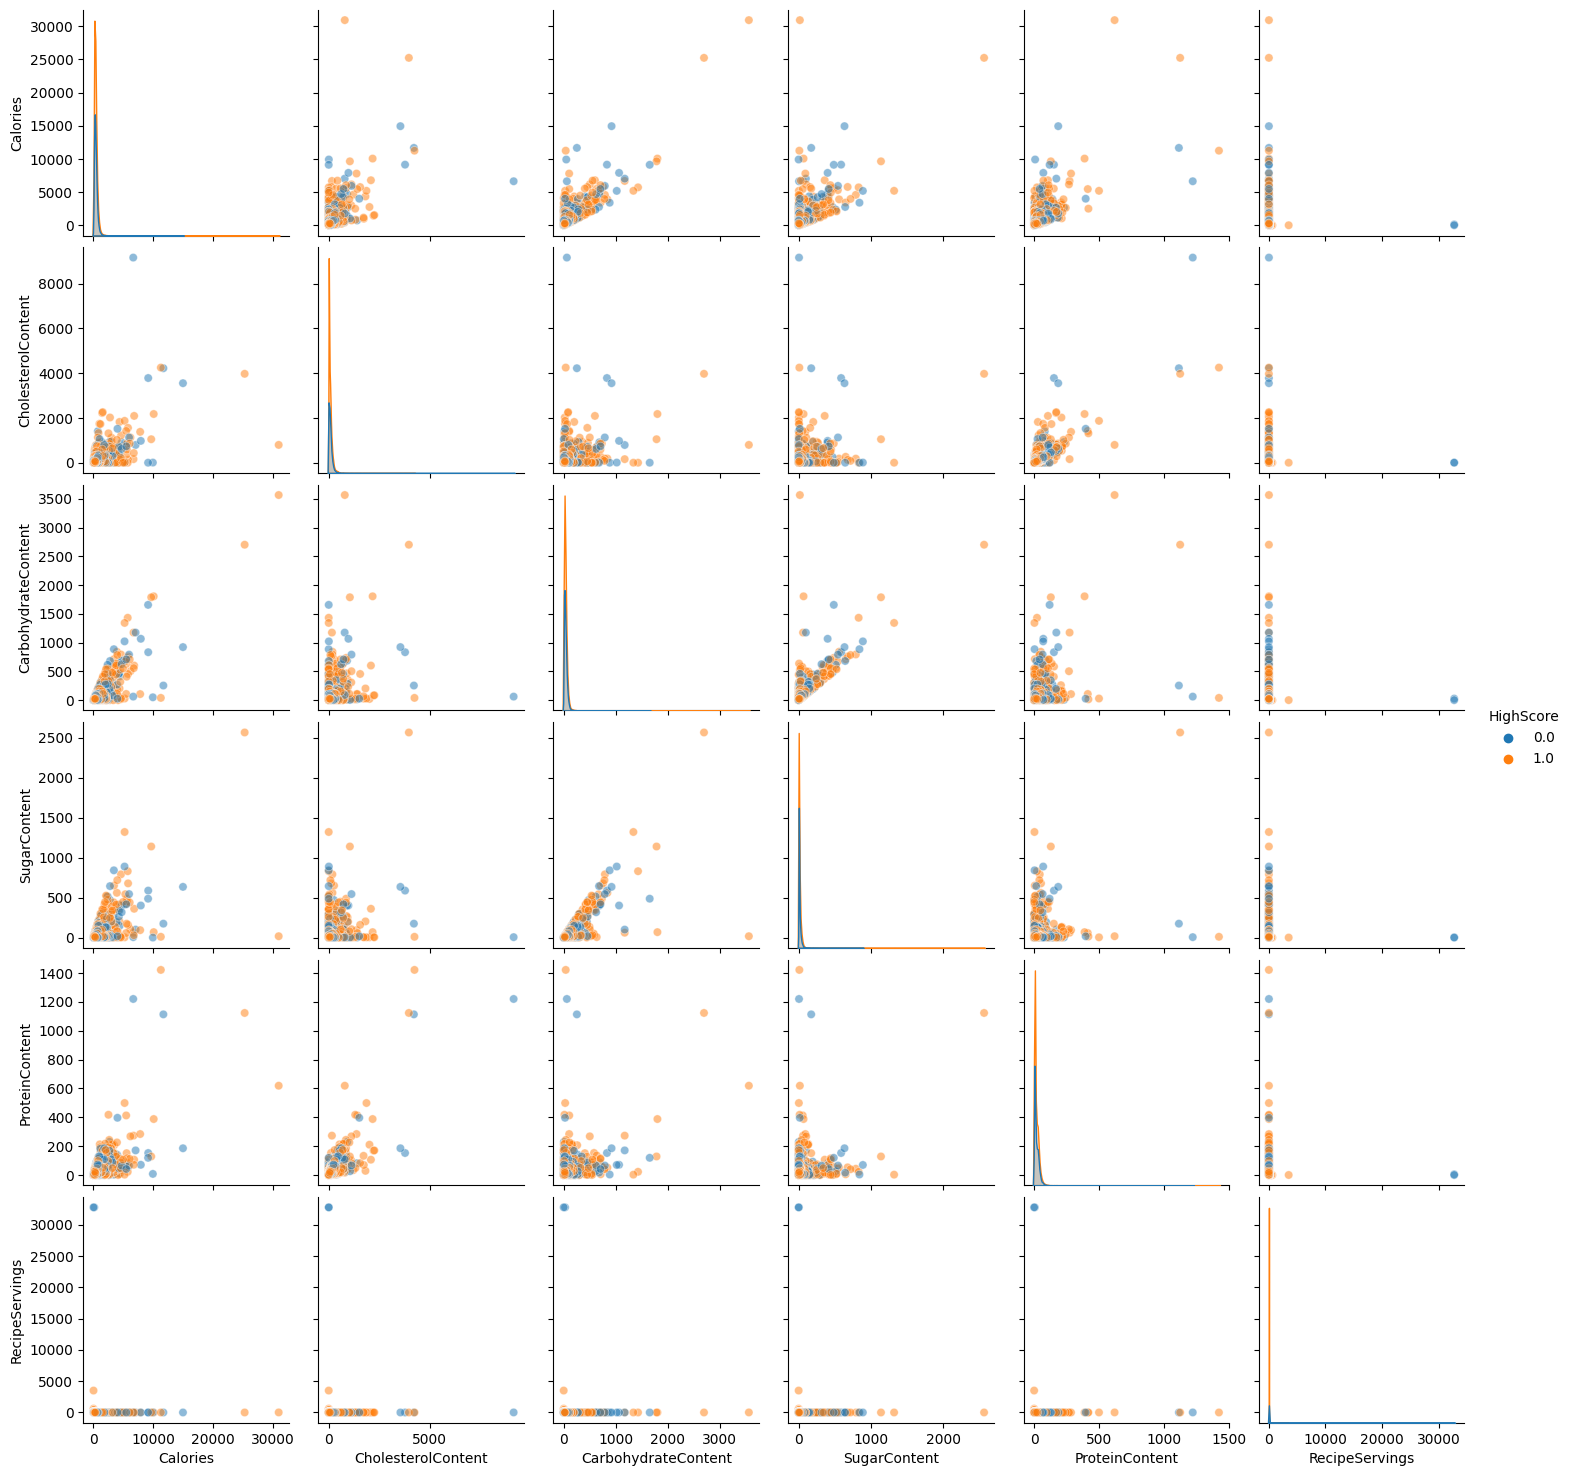

In [32]:
plt.clf()
sns.pairplot(data, vars=['Calories','CholesterolContent','CarbohydrateContent','SugarContent','ProteinContent','RecipeServings'], hue='HighScore', plot_kws={'alpha':0.5})
plt.show()

The pairplot shows that the dataset has many extreme values, because of which the relationship between different variables is not clearly visible. Some of the values does seem unreal, such as Recipe Serving size of more than 30000 or vary high calorie values.

### Identifying Outliers

Here, I have defined values outside of three standard deviations as extreme values and put them in the separate dataframe. Ideally, these values should be included in the model using preprocessing techniques to avoid the information loss. However, considering the size of the dataset and for simplicity, I have excluded them from the model.

In [2]:
def find_outliers(col):
    from scipy import stats
    z = np.abs(stats.zscore(col))
    id_outliers = np.where(z>3,True,False)
    return pd.Series(id_outliers,index=col.index)

Extreme_vals = pd.DataFrame()
cols = ['Calories','CholesterolContent',
       'CarbohydrateContent', 'SugarContent', 'ProteinContent',
       'RecipeServings']
for col in cols:
    out_df = data.loc[find_outliers(data[col])==True]
    Extreme_vals = pd.concat([Extreme_vals, out_df])
Extreme_vals = Extreme_vals.drop_duplicates(keep='first')

data = data[~data.index.isin(Extreme_vals.index)]
data.reset_index(drop=True, inplace=True)

Now, we can plot the pairplot again to undestand the numeric variables's distribution.

<Figure size 640x480 with 0 Axes>

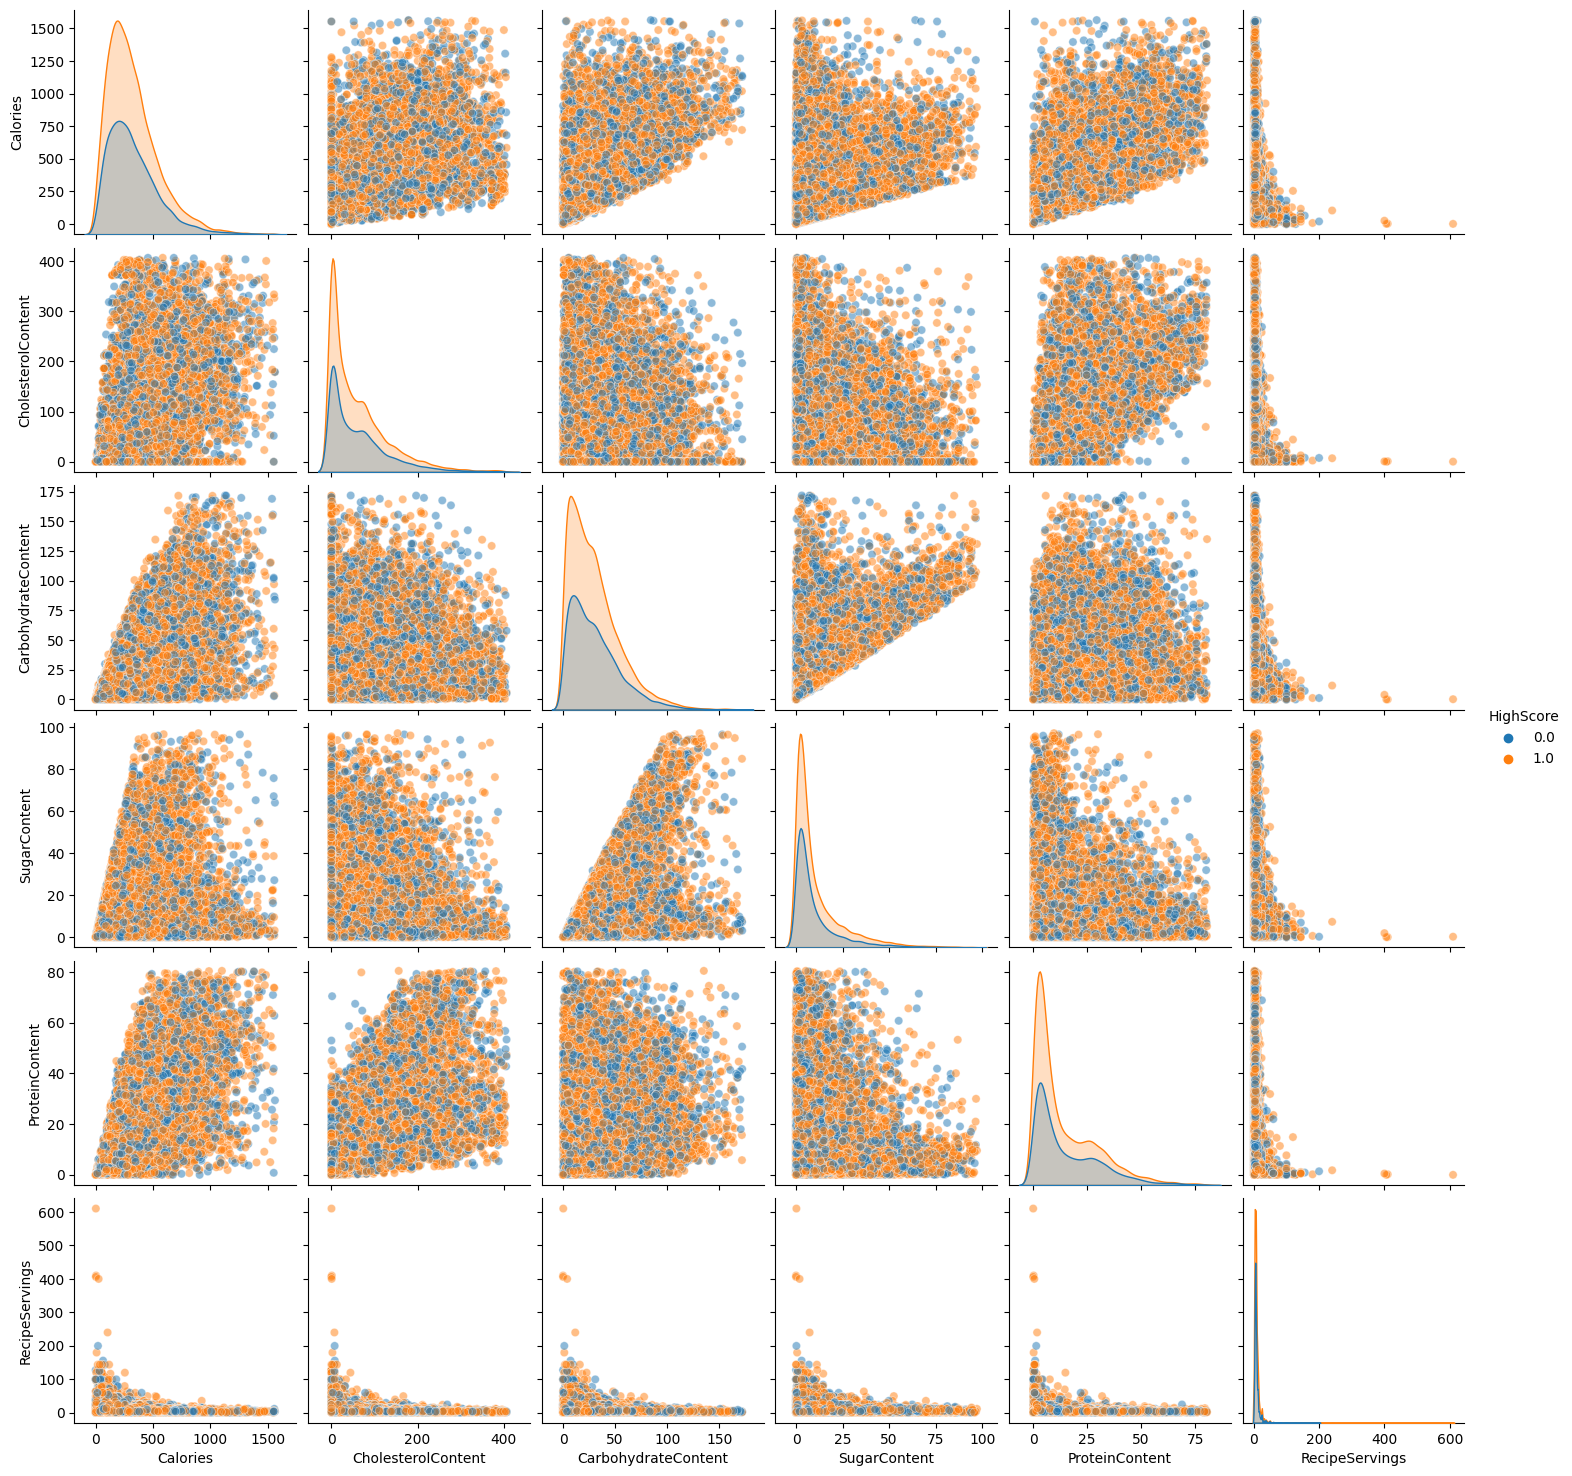

In [34]:
plt.clf()
sns.pairplot(data, vars=['Calories','CholesterolContent','CarbohydrateContent','SugarContent','ProteinContent','RecipeServings'], hue='HighScore', plot_kws={'alpha':0.5})
plt.show()

The pairplot shows how the HighScore labels are overlapped severely. We can note few points from this plot:
* The distribution is right skewed.
* '1' and '0' labels are not linearly separable, a simple linear model, such as Logistic Regression may not be very useful. We will have to try Decision Tree or Neural network or an ensamble technique.

### Cleaning Data

After looking at a skyview of our entire dataset, we will deal with individual columns now. Since, we don't need to join the dataframe to any other table, we can drop the 'RecipeID' column. 

In [3]:
data = data.drop('RecipeId', axis=1)

Now, we will look at the columns with text data.
* Many entries in recipe category are abreviated using special characters such as: '<' as 'less than', '/' as 'or' etc. These are repalced accordingly.
* All the leading and trailing spaces, other punctuation marks as well as inverted commas are removed.
* Words are coverted to lower case and missing values are filled with the empty string.

In [4]:
data['RecipeCategory'] = data['RecipeCategory'].str.strip().str.lower()
dict = {'<':'less than','/':' '}
for key, val in dict.items():
    data['RecipeCategory'] = data['RecipeCategory'].str.replace(key, val, regex=False)
data['RecipeCategory'] = data['RecipeCategory'].str.replace(r'[^0-9a-zA-Z ]', '', regex=True).str.replace("'",'')
data.RecipeCategory.fillna('', inplace=True)

### Top scoring recipes

Given below is the plot of top 25 recipe categories that receives the highscore.

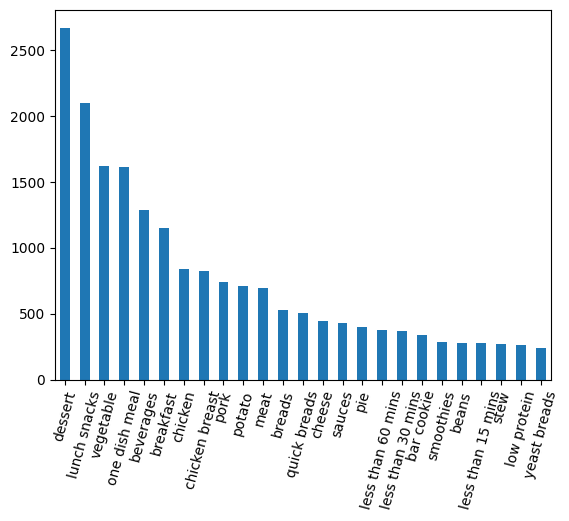

In [16]:
#plot high scoring recipes
plt.clf()
data[data['HighScore']==1]['RecipeCategory'].value_counts().head(25).plot(kind='bar')
plt.xticks(rotation = 75)
plt.show()

Similarly, 'Name' column is cleaned as well and then both the string type columns are merged. The connecting words such as 'the', 'and', 'in', 'with', etc. do not add much value to the model and their high frequency can influence the models performance. Hence, they are removed using 'nltk' library.

In [5]:

data['Name'] = data['Name'].str.strip().str.lower()
data['Name'] = data['Name'].str.replace(r'[^0-9a-zA-Z ]', '', regex=True).str.replace("'",'')

data['Name_Category'] = data['Name'].astype(str) + ' ' + data['RecipeCategory'].astype(str)

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
data['Name_Category'] = data['Name_Category'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print(data['Name_Category'].head(3))

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0            crock pot baked potato soup one dish meal
1    frittata di spaghetti spaghetti frittata break...
2                        berries italian cream dessert
Name: Name_Category, dtype: object


We will define 'HighScore' as 'y' variable and check the ratio of 1s and 0s.

In [6]:
y = data['HighScore']
data = data.drop('HighScore', axis=1)
y.describe()

count    42006.000000
mean         0.644932
std          0.478540
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HighScore, dtype: float64

The mean value of 0.645 means that around 64% of total records are labeled '1' while remaining labels are '0'.

### Separating text and numeric data

In [7]:
text_data = data['Name_Category']
numeric_data = data.drop(['Name','RecipeCategory','Name_Category'], axis=1)
print(text_data.info())
print(numeric_data.info())

<class 'pandas.core.series.Series'>
RangeIndex: 42006 entries, 0 to 42005
Series name: Name_Category
Non-Null Count  Dtype 
--------------  ----- 
42006 non-null  object
dtypes: object(1)
memory usage: 328.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42006 entries, 0 to 42005
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Calories             42006 non-null  float64
 1   CholesterolContent   42006 non-null  float64
 2   CarbohydrateContent  42006 non-null  float64
 3   SugarContent         42006 non-null  float64
 4   ProteinContent       42006 non-null  float64
 5   RecipeServings       42006 non-null  float64
dtypes: float64(6)
memory usage: 1.9 MB
None


### Correlation between numeric features
Now, we have the clean text data and missing values are also taken care of. Let's look at the correlation between valrious numeric variables.

<Figure size 1000x800 with 0 Axes>

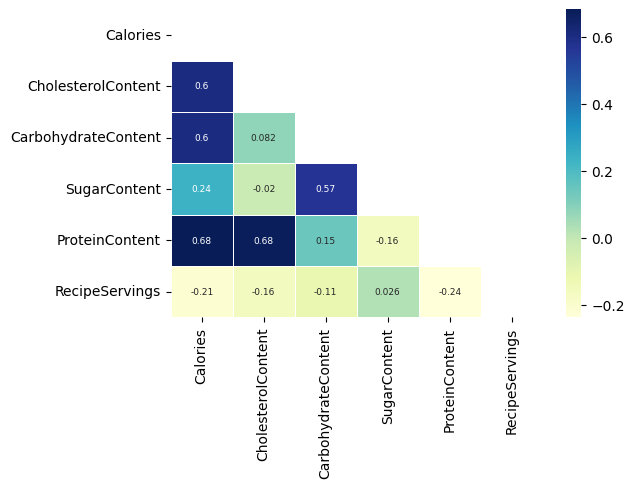

In [30]:
plt.clf()
plt.figure(figsize=(6,4))
corr = numeric_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(numeric_data.corr(),cmap="YlGnBu",linewidths=0.5,annot=True,annot_kws={"size":6.5},mask=mask)
plt.show()

* All ingredient features are highly correlated with 'Calories' except 'RecipeServings' which makes sense as serving size is independent of calorie content per unit quantity.
* 'SugarContent' with 'CarbohydrateContent' and 'ProteinContent' with 'CholesterolContent' are also highly correlated as expected.

# 3. Preprocessing the Dataframe

## Converting non-numeric features into numeric

There is still some minor but essential data preprocessing needed before we proceed towards building our machine learning model. I have divided these remaining preprocessing steps into two main tasks:

1. Converting the non-numeric data into numeric.
2. Scaling the feature values to a uniform range.

First, we will be converting all the non-numeric values into numeric ones. We do this for faster computation and for machine learning models developed using scikit-learn which require the data to be in a strictly numeric format.

To do so, I have used TfidfVectorizer that transforms text to feature vectors that can be used as input to estimator. 
Parameters used:
* _ngram_range_ is set to (1,2) to extract both unigrams and bigrams
* _max_features_ is kept 5000 to reduce the dimensionality of output CSR matrix
* used 'word_tokenize' from nltk library to make split words into tokens

In [8]:
# importing useful tools
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Tokenized words in text column to generate a CSR matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000, tokenizer=word_tokenize)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

print(tfidf_matrix.shape)

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(42006, 5000)


The output of the tfidf matrix can't be fed to a model, as it will become computationally infeasible. Hence, dimensionality reduction technique needs to be implemented. Since, scikit learn's PCA doesn't support csr matrix, I have used singular value decomposition tool TruncatedSVD. Truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).
Parameters used:
* _n_components_ set to 100, recommended value for LSA
* _algorithm_ set to 'arpack'. Default is 'Randomized', but 'arpack' proved to be faster.

In [9]:
#Used singular value decomposition technique to reduce the dimensionality and to filter top 100 features.
n_comp = 100
model = TruncatedSVD(n_components=n_comp, algorithm='arpack') #'arpack' proved faster than 'Randomized'
tdf = model.fit_transform(tfidf_matrix)
text_df = pd.DataFrame(tdf)

### Merging into one dataframe

In [10]:
new_data = text_df.merge(numeric_data, left_index=True, right_index=True)
new_data.shape
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42006 entries, 0 to 42005
Columns: 106 entries, 0 to RecipeServings
dtypes: float64(106)
memory usage: 34.0 MB


### Scaling the feature values to a uniform range

In [11]:
from sklearn.preprocessing import StandardScaler
scaled_data = StandardScaler().fit_transform(new_data)
scaled_data.shape

(42006, 106)

# 4. Building a Classification Model

## Fitting a Neural Network Model to the training set

Predicting if the recipe will recieve a Highscore or not is essentially a classification task. The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. This is a benchmark. Since, low scoring recipes here represents the minority class, A good machine learning model should have high recall value for '0' labels, which will be our key performance indicator here.

Which model should we pick? As we seen in our pairplot, a linear model will not give as a good performance for such highly overlapped data points. In, such cases Decision Tree based models or neural network might work well. First, we will start with sklearn's option for neural network, named, MLPClassifier. 

In [12]:
# Importing tools
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.3, random_state=13, stratify=y)

Parameters used:
* for basic model, _hidden_layer_sizes_ is set to (8,8,8), later we can try other sizes
* _activation_ is kept to default 'relu' to use the rectified linear unit function
* The default _solver_ ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score
* Let's up aour _max_iter_ value to 500.

In [17]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), solver='adam', max_iter=500, random_state=13)
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500, random_state=13)

### Predicting on training set

In [18]:
predict_train = mlp.predict(X_train)

<Figure size 640x480 with 0 Axes>

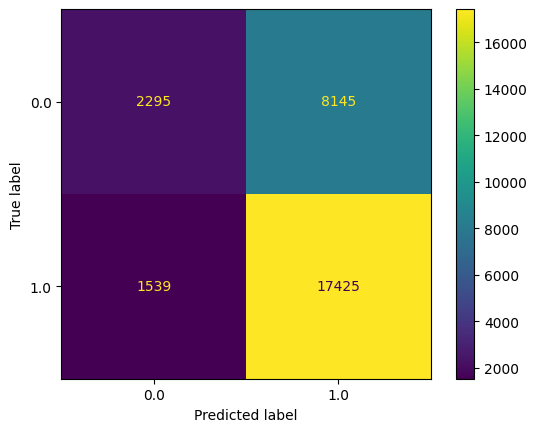

In [19]:
plt.clf()
ConfusionMatrixDisplay.from_predictions(y_train,predict_train)
plt.show()

In [20]:
print(classification_report(y_train,predict_train))

              precision    recall  f1-score   support

         0.0       0.60      0.22      0.32     10440
         1.0       0.68      0.92      0.78     18964

    accuracy                           0.67     29404
   macro avg       0.64      0.57      0.55     29404
weighted avg       0.65      0.67      0.62     29404



Here we can see the model is giving very low recall value for '0' class. Also, from confusion matrix we can say that model is inclined to label majority of records as '1'. Hence, to resolve this imbalance issue, oversampling of minority class is done on training data and model is fitted again as shown below.

### Oversampling the training set

In [22]:
from collections import Counter
import imblearn
from imblearn.over_sampling import RandomOverSampler

counter = Counter(y_train)
estimate = counter[0] / counter[1]
print(Counter(y_train))
print('Estimate: %.3f' % estimate)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(Counter(y_train))

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500, random_state=13)
mlp.fit(X_train,y_train)

Counter({1.0: 18964, 0.0: 18964})
Estimate: 1.000
Counter({1.0: 18964, 0.0: 18964})


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500, random_state=13)

In [23]:
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

<Figure size 640x480 with 0 Axes>

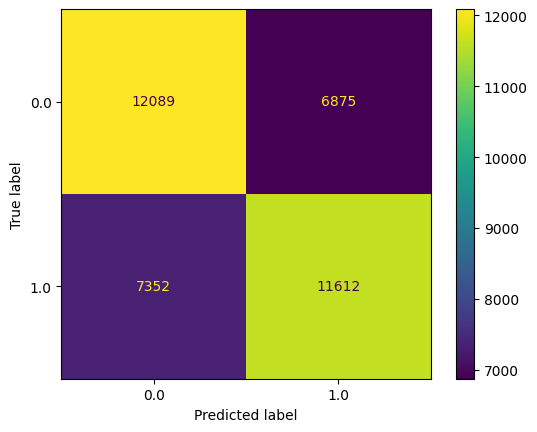

In [24]:
plt.clf()
ConfusionMatrixDisplay.from_predictions(y_train,predict_train)
plt.show()

In [25]:
print(classification_report(y_train,predict_train))

              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63     18964
         1.0       0.63      0.61      0.62     18964

    accuracy                           0.62     37928
   macro avg       0.62      0.62      0.62     37928
weighted avg       0.62      0.62      0.62     37928



In [26]:
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

         0.0       0.39      0.52      0.44      4475
         1.0       0.68      0.55      0.61      8127

    accuracy                           0.54     12602
   macro avg       0.53      0.54      0.53     12602
weighted avg       0.57      0.54      0.55     12602



Now, that is a better picture. Oversampling increased our recall value for '0' class when predicted on training set. But, for both training and test sets, it's still low. Now, we will try a Gradient Boosting model and see if that gives a better performance.

# 5. Training with XGBoost

Scikit learn's XGBClassifier is a gradient boosting model with default booster as decision tree. Hence, this can prove to be a good model for our problem. The parameters used for the models are described below:

* I have used XGBClassifier() with 25 boosting rounds to avoid long training times.
* To avoid overfitting the data _max_depth_ is kept 2.
* As observed while fitting neural network, to resolve the class imbalance issue, _scale_pos_weight_ parameter, which control the balance of positive and negative weights, is defined 0.5 as our estimate from counter for '0' class label is 0.551.
* _random_state_ is specified to an integer value to ensure repeatability of the results.

In [27]:
# import the tools
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(n_estimators=25, max_depth=2, scale_pos_weight=0.5, eval_metric='error', random_state=13)

# Fit it to the training set
xgb_clf.fit(X_train, y_train)

#predict on training set
preds_tr = xgb_clf.predict(X_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Calculate the accuracy
test_accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
train_accuracy = float(np.sum(preds_tr==y_train))/y_train.shape[0]
# Print the accuracy
print("Test accuracy:", test_accuracy)
print("Train accuracy:", train_accuracy)

print(classification_report(y_test, preds))

Test accuracy: 0.3562132994762736
Train accuracy: 0.5009755325880616
              precision    recall  f1-score   support

         0.0       0.36      1.00      0.52      4475
         1.0       0.82      0.00      0.00      8127

    accuracy                           0.36     12602
   macro avg       0.59      0.50      0.26     12602
weighted avg       0.65      0.36      0.19     12602



In [28]:
print(classification_report(y_train,preds_tr))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     18964
         1.0       0.86      0.00      0.00     18964

    accuracy                           0.50     37928
   macro avg       0.68      0.50      0.34     37928
weighted avg       0.68      0.50      0.34     37928



<Figure size 640x480 with 0 Axes>

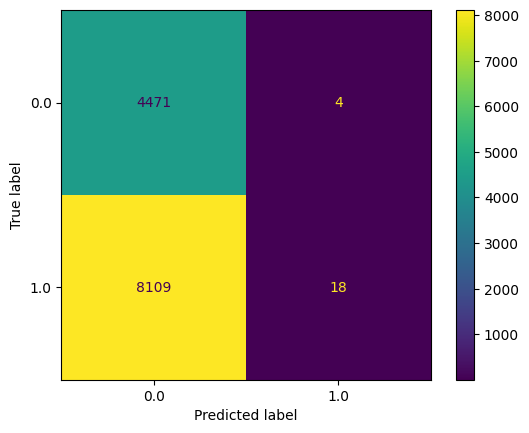

In [29]:
plt.clf()
ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

Now, that looks much better. Recall value of 1 for '0' class means that out of all recipes that recieved low score, all of them were predicted correctly. That satisfies our success criteria. But, is that enough?

# 6. Hyperparameter Tuning

The parameters specified in base xgboost model can be tuned to see if it gives better results. Grid search and random search are the most popular methods for hyperparameter tuning. However, grid search can get computationally expensive if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. This is why I have used random search because it doesn't try all the hyperparameter values.

Parameters used:
* _estimator_ is The estimator being fit, here it's XGBoost.
* _param_distributions_ is the distribution of possible hyperparameters to use.
* _cv_ is Number of cross-validation iterations, set to 3
* _n_iter_ is Number of hyperparameter combinations to choose from, set to 3 as we are tuning 3 parameters
* _scoring_ controls what metric that apply to the estimators evaluated, accuracy is not the target metric here, so, I set to 'recall_macro'.

In [34]:
# Define a parameter grid
rs_param_grid = {
    # max_depth: values from 3 to 11
    'max_depth': list((range(2,8))),
    # scale_pos_weight: values 0.5, 0.6, 0.7
    'scale_pos_weight': [0.5,0.6,0.7], 
    # n_estimators: values 10, 25, 40
    'n_estimators':[10,25,40]
    }


# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='error', random_state=13)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=rs_param_grid, cv=3, n_iter=3, scoring='recall_macro', random_state=13)

# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best accuracy found:", xgb_rs.best_score_)

Best parameters found: {'scale_pos_weight': 0.5, 'n_estimators': 25, 'max_depth': 5}
Best accuracy found: 0.5290024732723907


In [35]:
# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(n_estimators=25, max_depth=5, scale_pos_weight=0.5, eval_metric='error', random_state=13)

# Fit it to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.36      0.93      0.52      4475
         1.0       0.72      0.09      0.16      8127

    accuracy                           0.39     12602
   macro avg       0.54      0.51      0.34     12602
weighted avg       0.59      0.39      0.29     12602



Our target recall value is still high, that's good. These still lots of room for improvements thpugh. For now, we will declare this as our best model.

# 7. What next?

Although, the model is able to provide high recall value for '0' class, the accuracy is very poor. Also, we would want to predict High scoring recipes correctly as well. Improvements required in some areas to build a better model.

### Future Scope: What can be done

Due to limited computational capability of my device and time constraints, a simple analysis and modelling is done this time.
* Once, a model with convincing baseline accuracy is built, hyperparameter tuning can be done to improve the performance of the model.
* Scikit learn's xgbclassifier provides 'plot_importance' method. Once, the best parameters and best model is identified, feature importance can be plotted to provide the client with insights to help publish more and more high scoring recipes.  

### Recommendations

In a real world scenario, the likelihood of a person rating a recipe very high depends more on the category, name and description of the particular recipe and less on ingredient values or serving size. These factors also helps attracting visitors to the website in the first place. Hence, to utilize that extra information, the text description of each recipe should be provided. 

Using, Natural Language Processing, top recipe categories can be identified and a recommender system can be built for frequent visitors.

If time series data for this current dataset is provided, important insights about popularity trend of various recipies over the year can be found which can help take better decisions.

